### Pose Classifier (v2)

This notebook details using the pose information along with a ResNet/LSTM model to predict the three sentiment classses.

In Pose v1, we discovered that the pose information was not a good indicator of sentiment so we do not anticipate any major improvement to the prediction capability. 

---

Highlights:
- Best Performance: 
    - Epoch 3: loss: 0.7731 - accuracy: 0.6593 - val_loss: 0.9137 - val_accuracy: 0.5693
    - `drive/My Drive/checkpoints/pose-classifier-v2/final.h5`
- Contains a visualization of ResNet weights at the bottom

In [0]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [0]:
!ls

content      train_frames		    val_frames
drive	     train_frames_keypoints.tar.gz  val_frames_keypoints.tar.gz
sample_data  train_frames.tar.gz	    val_frames.tar.gz


In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/train_frames_keypoints.tar.gz' .

In [0]:
!tar -xzf train_frames_keypoints.tar.gz

In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/val_frames_keypoints.tar.gz' .


In [0]:
!tar -xzf val_frames_keypoints.tar.gz

In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/train_frames.tar.gz' .
!tar -xzf train_frames.tar.gz

!cp 'drive/My Drive/cs231n-project/datasets/emotiw/val_frames.tar.gz' .
!tar -xzf val_frames.tar.gz

In [0]:
!nvidia-smi

Sun May 24 03:53:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    30W / 250W |  15523MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join

class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates data based on a directory of frames and images
    Frames are added as the fourth channel
    """
    def __init__(self, dir, keyframe_dir, batch_size=32, frames_to_use=-1, shuffle=True):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.dir = dir
        self.keyframe_dir = keyframe_dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_map, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:

        {
            "vid1": [
                "frame1.jpg",
                "frame2.jpg",
                ...
            ]
        }

        """
        num_samples = 0
        min_frames = -1
        video_map = {}
        vid_to_cat = {}
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        for category_folder in category_folders:
            cat_path = join(self.dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                # frame = frame_101_7.mp4_8.jpg
                frame_arr = frame.split(".mp4_")
                vid_name = frame_arr[0]
                if vid_name not in video_map:
                    video_map[vid_name] = []
                    vid_to_cat[vid_name] = category_folder
                video_map[vid_name].append(frame)
            
            for k in video_map.keys():
                # make sure the frames for each video are in sorted order
                video_map[vid_name] = sorted(video_map[vid_name])
                if min_frames == -1 or len(video_map[vid_name]) < min_frames:
                    min_frames = len(video_map[vid_name])

        return list(video_map.keys()), video_map, vid_to_cat, len(vid_to_cat), min_frames

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_names = self.video_names[index*self.batch_size:(index+1)*self.batch_size]

        # print(f"Working on batch {index} with {len(video_names)} videos")

        num_frames = self.min_frames if self.frames_to_use == -1 else self.frames_to_use
        X = np.zeros((len(video_names), num_frames, IMG_HEIGHT, IMG_WIDTH, 4), dtype=np.uint8)
        y = []
        i = 0
        for vid in video_names:
            # print(vid)
            j = 0
            for frame in self.video_map[vid]:
                # print("   " + frame)
                keypoint_file = frame.replace(".jpg", "_keypoints.json")
                keypoint_file = join(join(self.keyframe_dir, self.video_to_class[vid]), keypoint_file)

                frame_path = join(join(self.dir, self.video_to_class[vid]), frame)
                img = cv2.imread(frame_path)

                with open(keypoint_file) as json_file:
                    keypoint_data = json.load(json_file)
                    for person in keypoint_data["people"]:
                        # Each person is assigned the label of the video
                        kp = np.array(person["pose_keypoints_2d"])

                        kp = np.reshape(kp, (-1, 3))

                        # Remove low probability values
                        kp = kp[(kp[:, 2] > 0.75), :] # N, 3

                        # Remove every third number, as that is the keypoint probability
                        kp = np.delete(kp, 2, 1) # N, 2

                        for e, row in enumerate(kp):
                            # Add the keypoints as the fourth dimension
                            if int(row[1]) >= 0 and int(row[1]) < IMG_HEIGHT and int(row[0]) >= 0 and int(row[0]) < IMG_WIDTH:
                                X[i, j, int(row[1]), int(row[0]), 3] = e

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Assume resized already
                # img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
                # print(img[0])
                X[i, j, :, :, 0:3] = img
                j += 1
                if j >= num_frames:
                    break

            y.append(int(self.video_to_class[vid]) - 1)
            # print(f"{vid} - {int(self.video_to_class[vid]) - 1}")
            i += 1
        y = np.array(y)
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        # print("on_epoch_end")
        if self.shuffle == True:
            np.random.shuffle(self.video_names)




In [0]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join

class DataPreviewGenerator(tf.keras.utils.Sequence):
    """
    Generates data based on a directory of frames. Keypoints are added directly onto the images
    Used primarily for visualization purposes.
    """
    def __init__(self, dir, keyframe_dir, batch_size=32, frames_to_use=-1, shuffle=True):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.dir = dir
        self.keyframe_dir = keyframe_dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_map, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:

        {
            "vid1": [
                "frame1.jpg",
                "frame2.jpg",
                ...
            ]
        }

        """
        num_samples = 0
        min_frames = -1
        video_map = {}
        vid_to_cat = {}
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        for category_folder in category_folders:
            cat_path = join(self.dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                # frame = frame_101_7.mp4_8.jpg
                frame_arr = frame.split(".mp4_")
                vid_name = frame_arr[0]
                if vid_name not in video_map:
                    video_map[vid_name] = []
                    vid_to_cat[vid_name] = category_folder
                video_map[vid_name].append(frame)
            
            for k in video_map.keys():
                # make sure the frames for each video are in sorted order
                video_map[vid_name] = sorted(video_map[vid_name])
                if min_frames == -1 or len(video_map[vid_name]) < min_frames:
                    min_frames = len(video_map[vid_name])

        return list(video_map.keys()), video_map, vid_to_cat, len(vid_to_cat), min_frames

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_names = self.video_names[index*self.batch_size:(index+1)*self.batch_size]

        # print(f"Working on batch {index} with {len(video_names)} videos")

        num_frames = self.min_frames if self.frames_to_use == -1 else self.frames_to_use
        X = np.zeros((len(video_names), num_frames, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
        y = []
        i = 0
        for vid in video_names:
            # print(vid)
            j = 0
            for frame in self.video_map[vid]:
                # print("   " + frame)
                keypoint_file = frame.replace(".jpg", "_keypoints.json")
                keypoint_file = join(join(self.keyframe_dir, self.video_to_class[vid]), keypoint_file)

                frame_path = join(join(self.dir, self.video_to_class[vid]), frame)
                img = cv2.imread(frame_path)

                with open(keypoint_file) as json_file:
                    keypoint_data = json.load(json_file)
                    for person in keypoint_data["people"]:
                        # Each person is assigned the label of the video
                        kp = np.array(person["pose_keypoints_2d"])

                        kp = np.reshape(kp, (-1, 3))

                        # Remove low probability values
                        kp = kp[(kp[:, 2] > 0.75), :] # N, 3

                        # Remove every third number, as that is the keypoint probability
                        kp = np.delete(kp, 2, 1) # N, 2

                        for row in kp:
                            cv2.circle(img, (int(row[0]), int(row[1])), 5, (0,255,0), -1)

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Assume resized already
                # img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
                # print(img[0])
                X[i, j, :, :, :] = img
                j += 1
                if j >= num_frames:
                    break

            y.append(int(self.video_to_class[vid]) - 1)
            # print(f"{vid} - {int(self.video_to_class[vid]) - 1}")
            i += 1
        y = np.array(y)
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        # print("on_epoch_end")
        if self.shuffle == True:
            np.random.shuffle(self.video_names)




In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
BATCH_SIZE = 32
MODEL_NAME = "pose-classifier-v2"
FRAMES = 12


In [0]:
import json
train_preview_generator = DataPreviewGenerator("train_frames", "content/train_frames_keypoints", frames_to_use=12, batch_size=BATCH_SIZE)
train_generator = DataGenerator("train_frames", "content/train_frames_keypoints", frames_to_use=12, batch_size=BATCH_SIZE)
validation_generator = DataGenerator("val_frames", "content/val_frames_keypoints", frames_to_use=12, batch_size=BATCH_SIZE)

X, y = train_generator.__getitem__(0)


Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 13
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 13
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 13


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


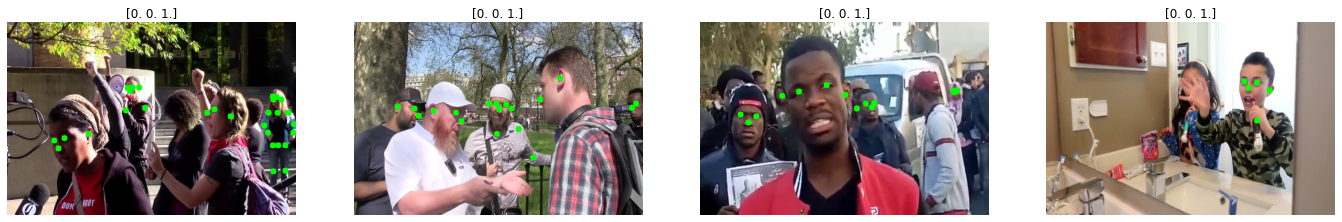

In [0]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30))
    for n in range(4):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(image_batch[n, 0])
          plt.title(label_batch[n])
          plt.axis('off')
image_batch, label_batch = train_preview_generator.__getitem__(1)
show_batch(image_batch, label_batch)

In [0]:
from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    period=1)

def create_model(inputs):
    base_model = get_base_model()
    base_model.trainable = False
    print(inputs.shape)
    x1 = tf.keras.layers.TimeDistributed(base_model)(inputs[:, :, :, :, 0:3])
    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x1)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(inputs[:, :, :, :, 3])
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(filters=40, kernel_size=(3, 3), padding='same')(x2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

    x = tf.keras.layers.Add()([x1, x2])
    x = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 4))
model = create_model(inputs)
model.summary()




(None, 12, 320, 480, 4)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_11 (T [(None, 12, 320, 480 0           input_20[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_10 (T [(None, 12, 320, 480 0           input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 320, 64)  276544      tf_op_layer_strided_slice_11[0][0
____________________________________________________________________

In [0]:
model.evaluate(train_generator, steps = 3)

3/3 [==============================] - 4s 1s/step - loss: 1.0573 - accuracy: 0.4062


[1.057324767112732, 0.40625]

In [0]:
import pickle
history = model.fit(
          train_generator,
          epochs=15,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)


model.save(f"drive/My Drive/checkpoints/{MODEL_NAME}/m1.h5")

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 0.9919 - accuracy: 0.5098
Epoch 00001: saving model to drive/My Drive/checkpoints/pose-classifier-v2/cp-0001.ckpt
83/83 [==============================] - 274s 3s/step - loss: 0.9919 - accuracy: 0.5098 - val_loss: 0.9658 - val_accuracy: 0.5326
Epoch 2/15
83/83 [==============================] - ETA: 0s - loss: 0.8533 - accuracy: 0.6246
Epoch 00002: saving model to drive/My Drive/checkpoints/pose-classifier-v2/cp-0002.ckpt
83/83 [==============================] - 246s 3s/step - loss: 0.8533 - accuracy: 0.6246 - val_loss: 0.9103 - val_accuracy: 0.5666
Epoch 3/15
83/83 [==============================] - ETA: 0s - loss: 0.7731 - accuracy: 0.6593
Epoch 00003: saving model to drive/My Drive/checkpoints/pose-classifier-v2/cp-0003.ckpt
83/83 [==============================] - 244s 3s/step - loss: 0.7731 - accuracy: 0.6593 - val_loss: 0.9137 - val_accuracy: 0.5693
Epoch 4/15
83/83 [==============================] - ETA: 0s - lo

In [0]:
### Load model from epoch 3 and fine tune some more

model.load_weights(f"drive/My Drive/checkpoints/{MODEL_NAME}/cp-0003.ckpt")
model.save(f"drive/My Drive/checkpoints/{MODEL_NAME}/epoch3.h5")



In [0]:
from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/fine-tune-cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    period=1)

def create_model(inputs):
    base_model = get_base_model()
    base_model.trainable = True
    for layer in base_model.layers[:160]:
        layer.trainable = False
    for layer in base_model.layers[160:]:
        layer.trainable = True

    x1 = tf.keras.layers.TimeDistributed(base_model)(inputs[:, :, :, :, 0:3])
    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x1)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(inputs[:, :, :, :, 3])
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(filters=40, kernel_size=(3, 3), padding='same')(x2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

    x = tf.keras.layers.Add()([x1, x2])
    x = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001/100),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 4))
model = create_model(inputs)
model.load_weights(f"drive/My Drive/checkpoints/{MODEL_NAME}/cp-0003.ckpt")
model.summary()




Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_25 (T [(None, 12, 320, 480 0           input_34[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_24 (T [(None, 12, 320, 480 0           input_34[0][0]                   
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 12, 320, 64)  276544      tf_op_layer_strided_slice_25[0][0
___________________________________________________________________________________________

In [0]:
import json
train_generator = DataGenerator("train_frames", "content/train_frames_keypoints", frames_to_use=12, batch_size=8)
validation_generator = DataGenerator("val_frames", "content/val_frames_keypoints", frames_to_use=12, batch_size=8)

X, y = train_generator.__getitem__(0)


Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 13
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 13


In [0]:
import pickle
history = model.fit(
          train_generator,
          epochs=5,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history-fine-tune.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

model.save(f"drive/My Drive/checkpoints/{MODEL_NAME}/m2.h5")

Epoch 1/5
332/332 [==============================] - ETA: 0s - loss: 0.8328 - accuracy: 0.6322
Epoch 00001: saving model to drive/My Drive/checkpoints/pose-classifier-v2/fine-tune-cp-0001.ckpt
332/332 [==============================] - 260s 782ms/step - loss: 0.8328 - accuracy: 0.6322 - val_loss: 1.0027 - val_accuracy: 0.5342
Epoch 2/5
332/332 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.7116
Epoch 00002: saving model to drive/My Drive/checkpoints/pose-classifier-v2/fine-tune-cp-0002.ckpt
332/332 [==============================] - 260s 782ms/step - loss: 0.6825 - accuracy: 0.7116 - val_loss: 1.0419 - val_accuracy: 0.5237
Epoch 3/5
332/332 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7579
Epoch 00003: saving model to drive/My Drive/checkpoints/pose-classifier-v2/fine-tune-cp-0003.ckpt
332/332 [==============================] - 259s 781ms/step - loss: 0.5919 - accuracy: 0.7579 - val_loss: 1.0209 - val_accuracy: 0.5289
Epoch 4/5
332/33

174
(80, 120, 64)


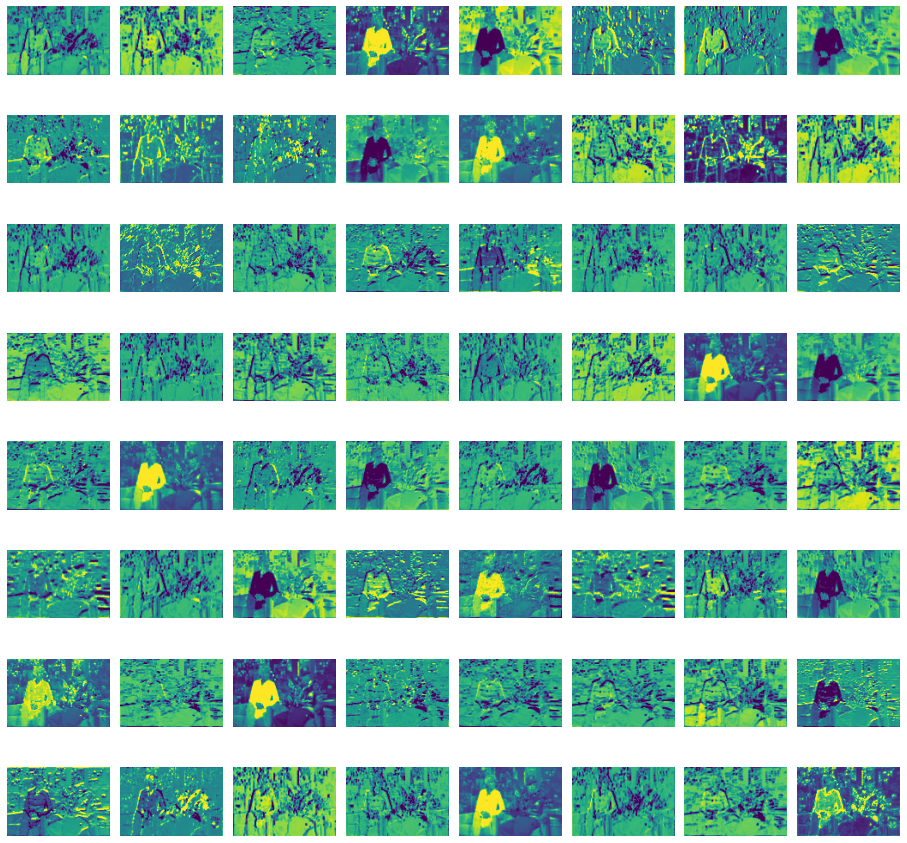

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


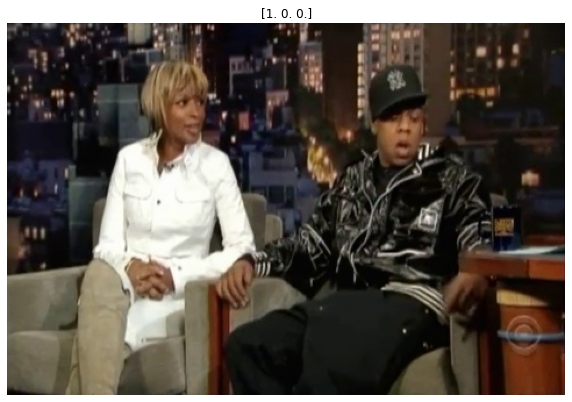

In [158]:
# tf.compat.v1.enable_eager_execution()
from keras.models import Model
import matplotlib.pyplot as plt

resnet = get_base_model()

# layer_outputs = [layer.output for layer in model.layers[1].layers if not layer.name.startswith('input')]
# activation_model = Model(inputs=model.input, outputs=layer_outputs)
# activation_model

def plot_activations(layer_idx, activations):
    layer_activation = activations[layer_idx][0]
    print(layer_activation.shape)
    n_row = 8
    n_column = min(layer_activation.shape[-1], 8)
    
    f, ax = plt.subplots(n_row, n_column)
    for i in range(n_row):
        for j in range(n_column):
            channel_image = layer_activation[:, :, i*n_column+j]
            # image post-processing for better visualization
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        
            ax[i, j].imshow(channel_image, cmap='viridis')
            ax[i, j].axis('off')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    plt.subplots_adjust(wspace=0.1, hspace=0)
    f.set_size_inches(16, 16)
    plt.show()

def show_img(img, t):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.title(t)
    plt.axis('off')

layer_outputs = [layer.output for layer in resnet.layers if not layer.name.startswith('input')]
print(len(layer_outputs))
image_batch_, label_batch = train_generator.__getitem__(1)
image_num = 2
ib = image_batch_[image_num, 0][:, :, 0:3]
activations_input = np.array([ib])
# print(activations_input.shape)
activation_model = tf.keras.Model(inputs=resnet.input, outputs=layer_outputs)
# activations = activation_model(activations_input)
activations = activation_model.predict(activations_input)
plot_activations(6, activations)
show_img(ib, label_batch[image_num])

In [0]:
### Save the chosen model

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 4))
model = create_model(inputs)
model.load_weights(f"drive/My Drive/checkpoints/{MODEL_NAME}/cp-0003.ckpt")
model.save(f"drive/My Drive/checkpoints/{MODEL_NAME}/final.h5")